<b> <font size="5"> Differential gene expression analysis </font> </b> <br> 
<font size="5"> to identify age-regulated genes in Controls and Cases separately </font> <br>
<b> <font size="5">  followed by rank-rank hypergeometric overlao (RRHO) analysis </font> </b> 

Perform differential expression analysis for age-regulated genes separetly in Controls and Cases
<br> then perform RRHO to examine concordance and discordance in gene expression patterns

Author: ASF <br>
Date: 20231124

In [1]:
# Load libraries
suppressPackageStartupMessages({
library(SingleCellExperiment)
library(zellkonverter)
library(dreamlet)
library(zenith)
library(DelayedArray)
library(GSEABase)
#library(muscat)
library(cowplot)
#library(scater)
library(tidyverse)
#library(kableExtra)
library(qvalue)
library(scattermore)
library(RColorBrewer)
library(corrplot)
library(viridis)
library(dplyr)
library(org.Hs.eg.db)
library(EnrichmentBrowser)
library(ggrepel)
library(rhdf5)
library(HDF5Array)
library(readxl)
library(writexl)
})

# Read in data and make pseudobulk

## read in h5ad files

In [2]:
# read H5AD files
# ca 6 min 
file <- "../datasets/adata_celltypes_after_manual_curation_Controls_20231120.h5ad"
sce_controls <- readH5AD(file, use_hdf5=TRUE, verbose=FALSE)

# make sure batch is a character
sce_controls$X6.Batch <- as.character(sce_controls$X6.Batch)

Warning message:
“The names of these selected uns items have been modified to match R
conventions: '6-Batch_colors' -> 'X6.Batch_colors'”
Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”


In [3]:
# read H5AD files
# ca 6 min
file <- "../datasets/adata_celltypes_after_manual_curation_Cases_20231120.h5ad"
sce_cases <- readH5AD(file, use_hdf5=TRUE, verbose=FALSE)

# Set missing RIN to median
sce_cases$RIN[is.na(sce_cases$RIN)] = median(c(sce_cases$RIN, sce_controls$RIN) , na.rm=TRUE) 

# make sure batch is a character
sce_cases$X6.Batch <- as.character(sce_cases$X6.Batch)

Warning message:
“The names of these selected uns items have been modified to match R
conventions: '6-Batch_colors' -> 'X6.Batch_colors'”
Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”


## compute pseudobulk

In [4]:
# celltypes_final
# counts here should represent the raw counts
# takes 0.5 min
pb_controls_final_ct <- aggregateToPseudoBulk(sce_controls,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "individual", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

pb_cases_final_ct <- aggregateToPseudoBulk(sce_cases,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "individual", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

In [5]:
# read in PC1_hidden_noise
PC1 <- read_xlsx(path = "../datasets/PC1_hidden_confounders.xlsx")

colData(pb_controls_final_ct)$PC1 <- PC1[PC1$individual %in% c(colData(pb_controls_final_ct)$SU.Number),]$PC1_hidden_noise
colData(pb_cases_final_ct)$PC1 <- PC1[PC1$individual %in% c(colData(pb_cases_final_ct)$SU.Number),]$PC1_hidden_noise

# Process data

## Normalization

In [6]:
form <- ~ (1|X6.Batch) + (1|Sex) + Age + PMI + RIN + Brain.pH + PC1

In [7]:
# Normalize and apply voom
# N(Controls)=33; 0.75*33 = 25 -> min.samples
res.proc_controls <- processAssays(pb_controls_final_ct, form, min.count=10, min.prop=0.8, min.cells=5, min.samples=25,
  BPPARAM = SnowParam(12))

  Exc_L2-3...
4.6 mins

  Exc_L3-5...
3.9 mins

  Exc_L4-6_1...
4.3 mins

  Exc_L4-6_2...
4.3 mins

  Exc_L4-6_3...
4 mins

  Exc_L5-6_1...
3.6 mins

  Exc_L5-6_2...
3.8 mins

  Exc_L5-6_HTR2C...
3.6 mins

  In_LAMP5_1...
3.7 mins

  In_LAMP5_2...
3.7 mins

  In_PVALB_Ba...
4.2 mins

  In_PVALB_Ch...
3.6 mins

  In_RELN...
4.1 mins

  In_SST...
4.2 mins

  In_VIP...
4.3 mins

  Astro_FB...
3.6 mins

  Astro_PP...
4.1 mins

  Endothelial...
3.8 mins

  Microglia...
3.6 mins

  Oligodendrocyte...
4 mins

  OPC...
4 mins



In [8]:
details(res.proc_controls)

assay,n_retain,formula,formDropsTerms,n_genes,n_errors,error_initial
<chr>,<int>,<chr>,<lgl>,<int>,<int>,<lgl>
Exc_L2-3,33,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,17585,0,FALSE
Exc_L3-5,33,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,8607,0,FALSE
Exc_L4-6_1,33,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,12625,0,FALSE
Exc_L4-6_2,33,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,12005,0,FALSE
Exc_L4-6_3,32,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,9012,0,FALSE
Exc_L5-6_1,30,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,6021,0,FALSE
Exc_L5-6_2,25,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,1665,0,FALSE
Exc_L5-6_HTR2C,32,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,3860,0,FALSE
In_LAMP5_1,33,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,6990,0,FALSE


In [9]:
# Normalize and apply voom
# N(Cases)=54; 0.75*54 = 40,5 -> min.samples
res.proc_cases <-  processAssays(pb_cases_final_ct, form, min.count=10, min.prop=0.8, min.cells=5, 
                                 min.samples=41, BPPARAM = SnowParam(12))

  Exc_L2-3...
4.9 mins

  Exc_L3-5...
4.1 mins

  Exc_L4-6_1...
4.6 mins

  Exc_L4-6_2...
4.5 mins

  Exc_L4-6_3...
4.3 mins

  Exc_L5-6_1...
3.9 mins

  Exc_L5-6_2...
3.8 mins

  Exc_L5-6_HTR2C...
3.8 mins

  In_LAMP5_1...
4 mins

  In_LAMP5_2...
3.9 mins

  In_PVALB_Ba...
4.5 mins

  In_PVALB_Ch...
3.9 mins

  In_RELN...
4.3 mins

  In_SST...
4.3 mins

  In_VIP...
4.5 mins

  Astro_FB...
4 mins

  Astro_PP...
4.3 mins

  Endothelial...
4 mins

  Microglia...
3.8 mins

  Oligodendrocyte...
4.1 mins

  OPC...
4.2 mins



In [10]:
details(res.proc_cases)

assay,n_retain,formula,formDropsTerms,n_genes,n_errors,error_initial
<chr>,<int>,<chr>,<lgl>,<int>,<int>,<lgl>
Exc_L2-3,54,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,17961,0,FALSE
Exc_L3-5,54,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,8420,0,FALSE
Exc_L4-6_1,54,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,12999,0,FALSE
Exc_L4-6_2,54,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,12290,0,FALSE
Exc_L4-6_3,52,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,10246,0,FALSE
Exc_L5-6_1,50,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,6758,0,FALSE
Exc_L5-6_2,45,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,1964,0,FALSE
Exc_L5-6_HTR2C,53,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,4627,0,FALSE
In_LAMP5_1,54,~(1 | X6.Batch) + (1 | Sex) + Age + PMI + RIN + Brain.pH + PC1,FALSE,7598,0,FALSE


# Variance Partition

In [11]:
res.vp_controls <- fitVarPart(res.proc_controls, form, BPPARAM = SnowParam(12))

  Exc_L2-3...
1.5 mins

  Exc_L3-5...
1.1 mins

  Exc_L4-6_1...
1.3 mins

  Exc_L4-6_2...
1.2 mins

  Exc_L4-6_3...
1.1 mins

  Exc_L5-6_1...
57 secs

  Exc_L5-6_2...
44 secs

  Exc_L5-6_HTR2C...
49 secs

  In_LAMP5_1...
58 secs

  In_LAMP5_2...
53 secs

  In_PVALB_Ba...
1.2 mins

  In_PVALB_Ch...
53 secs

  In_RELN...
1.2 mins

  In_SST...
1.2 mins

  In_VIP...
1.3 mins

  Astro_FB...
51 secs

  Astro_PP...
1.1 mins

  Endothelial...
46 secs

  Microglia...
55 secs

  Oligodendrocyte...
1 mins

  OPC...
1.1 mins






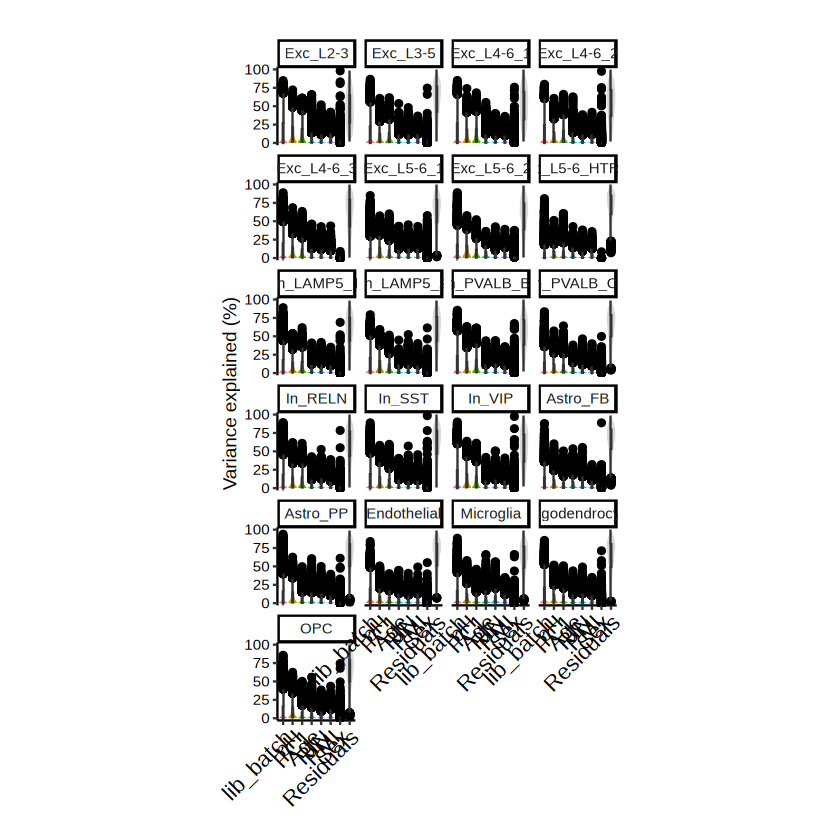

In [12]:
#colnames(res.vp)
colnames(res.vp_controls)[colnames(res.vp_controls) == "X6.Batch"] = 'lib_batch'
colnames(res.vp_controls)[colnames(res.vp_controls) == "Brain.pH"] = 'pH'
 
plotVarPart( sortCols(res.vp_controls), label.angle=45, ncol=4 )

In [13]:
res.vp_cases  <- fitVarPart(res.proc_cases, form, BPPARAM = SnowParam(12))

  Exc_L2-3...
1.6 mins

  Exc_L3-5...
1.1 mins

  Exc_L4-6_1...
1.3 mins

  Exc_L4-6_2...
1.3 mins

  Exc_L4-6_3...
1.2 mins

  Exc_L5-6_1...
58 secs

  Exc_L5-6_2...
46 secs

  Exc_L5-6_HTR2C...
53 secs

  In_LAMP5_1...
1.1 mins

  In_LAMP5_2...
55 secs

  In_PVALB_Ba...
1.2 mins

  In_PVALB_Ch...
56 secs

  In_RELN...
1.2 mins

  In_SST...
1.2 mins

  In_VIP...
1.3 mins

  Astro_FB...
54 secs

  Astro_PP...
1.2 mins

  Endothelial...
47 secs

  Microglia...
52 secs

  Oligodendrocyte...
1.1 mins

  OPC...
1.1 mins






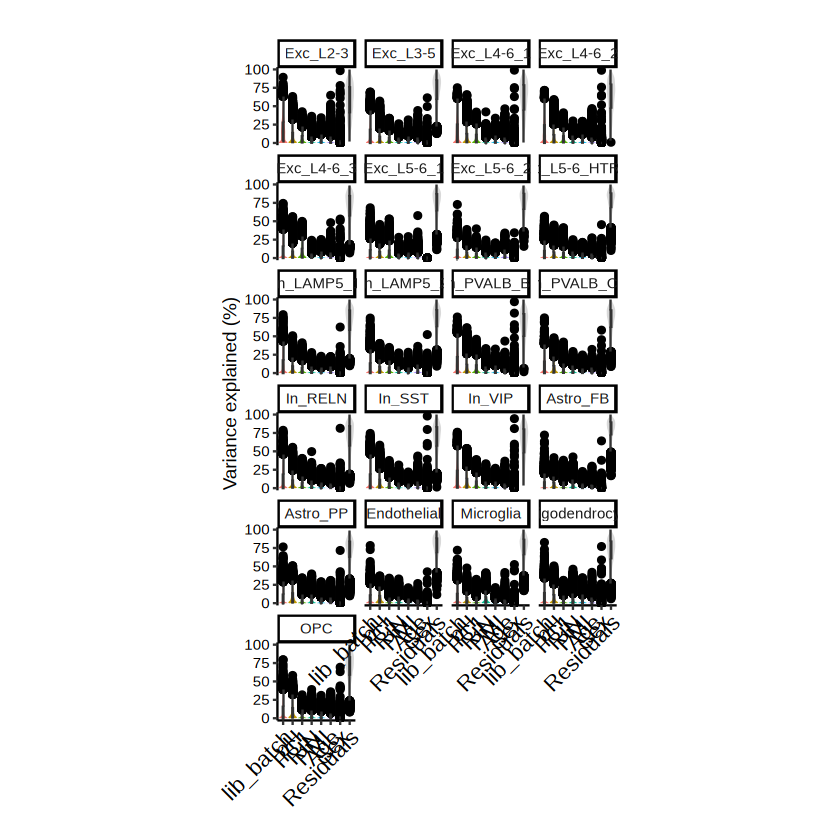

In [14]:
#colnames(res.vp)
colnames(res.vp_cases)[colnames(res.vp_cases) == "X6.Batch"] = 'lib_batch'
colnames(res.vp_cases)[colnames(res.vp_cases) == "Brain.pH"] = 'pH'
 
plotVarPart( sortCols(res.vp_cases), label.angle=45, ncol=4 )

In [ ]:
#save the plots

In [15]:
#20231124
pdf(file = "../figures/dreamlet_Variance_P_Controls_20231124.pdf", 
    width = 12,
    height = 14) 

plotVarPart( sortCols(res.vp_controls), label.angle=45, ncol=4,
           col=c("#f9c29b","#fc8814", "#4f7eae","#172d44","#1a2e18", "#508c49", "#4f3a52","#652d05", "#500050"))
dev.off()

png 
  2

In [16]:
#20231124
pdf(file = "../figures/dreamlet_Variance_P_Cases_20231124.pdf", 
    width = 12,
    height = 14) 

plotVarPart( sortCols(res.vp_cases),, label.angle=45, ncol=4, 
            col=c("#f9c29b","#fc8814", "#4f7eae","#172d44","#1a2e18", "#508c49", "#4f3a52","#652d05", "#500050"))
dev.off()

png 
  2

# Differential Expression 

## Controls

In [17]:
# Differential expression: dreamlet analysis

form <- ~ (1|X6.Batch) + (1|Sex) + Age + PMI + RIN + Brain.pH + PC1

fit_controls <- dreamlet(res.proc_controls, form, BPPARAM = SnowParam(12))

  Exc_L2-3...
15 mins

  Exc_L3-5...
7.5 mins

  Exc_L4-6_1...
11 mins

  Exc_L4-6_2...
10 mins

  Exc_L4-6_3...
8.1 mins

  Exc_L5-6_1...
5.4 mins

  Exc_L5-6_2...
2.3 mins

  Exc_L5-6_HTR2C...
3.6 mins

  In_LAMP5_1...
6.1 mins

  In_LAMP5_2...
4.7 mins

  In_PVALB_Ba...
10 mins

  In_PVALB_Ch...
4.6 mins

  In_RELN...
8.8 mins

  In_SST...
9.6 mins

  In_VIP...
11 mins

  Astro_FB...
4.4 mins

  Astro_PP...
8.6 mins

  Endothelial...
3.4 mins

  Microglia...
5.2 mins

  Oligodendrocyte...
7.9 mins

  OPC...
8.2 mins


Of 173,528 models fit across all assays, 0.0962% failed




In [18]:
DE_results_Age_ctrls <- fit_controls %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age_ctrls <- as.data.frame(DE_results_Age_ctrls)

In [19]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_res_Age_list_controls <- list()
for (celltype in assayNames(fit_controls)){
    DE_res_Age_list_controls[[celltype]] <- DE_results_Age_ctrls[DE_results_Age_ctrls$assay==celltype,] 
}

In [20]:
library(writexl)
#supply a named list of df to write_xlsx() so that each df is put in a separate sheet of the same excel file
write_xlsx(DE_res_Age_list_controls, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Ctrls_20231124.xlsx", col_names = TRUE)

## Cases

In [21]:
form <- ~ (1|X6.Batch) + (1|Sex) + Age + PMI + RIN + Brain.pH + PC1

fit_cases <- dreamlet(res.proc_cases, form, BPPARAM = SnowParam(12))

  Exc_L2-3...
15 mins

  Exc_L3-5...
7.8 mins

  Exc_L4-6_1...
11 mins

  Exc_L4-6_2...
11 mins

  Exc_L4-6_3...
9.2 mins

  Exc_L5-6_1...
6.5 mins

  Exc_L5-6_2...
2.4 mins

  Exc_L5-6_HTR2C...
4.8 mins

  In_LAMP5_1...
7.1 mins

  In_LAMP5_2...
5.2 mins

  In_PVALB_Ba...
10 mins

  In_PVALB_Ch...
5.1 mins

  In_RELN...
9.4 mins

  In_SST...
9.2 mins

  In_VIP...
11 mins

  Astro_FB...
4.9 mins

  Astro_PP...
9.4 mins

  Endothelial...
2.9 mins

  Microglia...
4.5 mins

  Oligodendrocyte...
8 mins

  OPC...
8.6 mins


Of 178,121 models fit across all assays, 0.123% failed




In [22]:
DE_results_Age_cases <- fit_cases %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age_cases <- as.data.frame(DE_results_Age_cases)

In [23]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_res_Age_list_cases <- list()
for (celltype in assayNames(fit_cases)){
    DE_res_Age_list_cases[[celltype]] <- DE_results_Age_cases[DE_results_Age_cases$assay==celltype,] 
}

In [24]:
write_xlsx(DE_res_Age_list_cases, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Cases_20231124.xlsx", col_names = TRUE)

## Summarize results

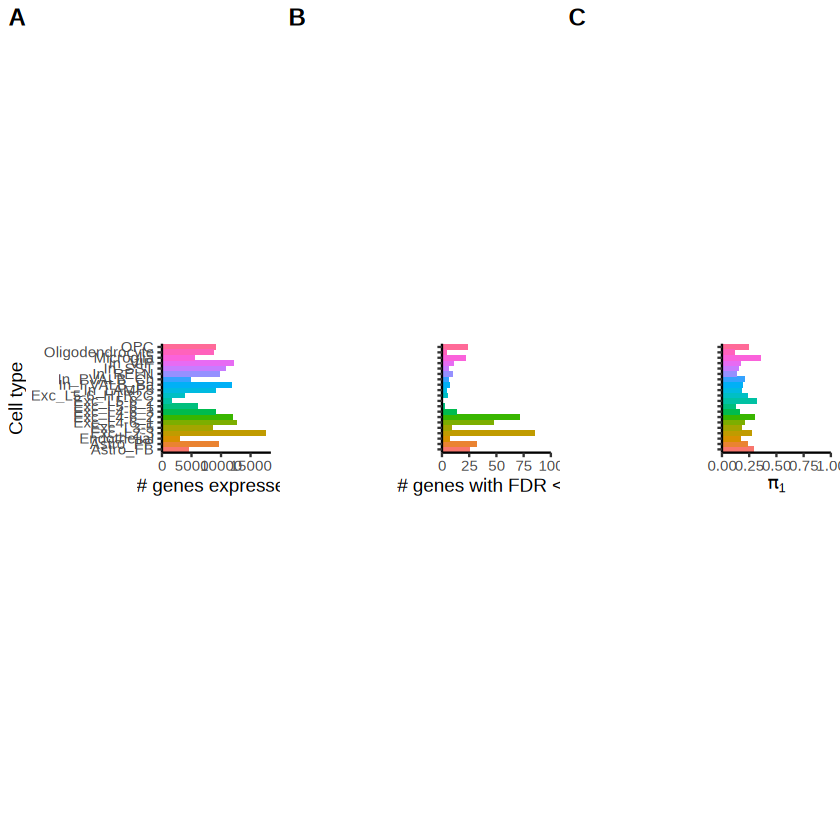

In [36]:
### Summarize differential expression 
### FDR <0.05
# Summarize differential expression for each coef and assay
df_de_controls = fit_controls %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes = length(adj.P.Val), 
      nDE = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
  mutate(assay = factor(assay))  

ymax = 1.05*max(df_de_controls$nGenes)
fig1 = ggplot(df_de_controls, aes(nGenes, assay, fill=assay)) + 
    geom_bar(stat="identity") + 
    theme_classic() +
    theme(aspect.ratio=1, legend.position="none") +
    scale_x_continuous(limits=c(0,ymax), expand=c(0,0)) +
    xlab("# genes expressed") +
    ylab("Cell type") 

ymax = max(1.05*max(df_de_controls$nDE), 100)
fig2 = ggplot(df_de_controls, aes(nDE, assay, fill=assay)) + 
    geom_bar(stat="identity") + 
    theme_classic() +
    theme(aspect.ratio=1, legend.position="none", axis.text.y=element_blank()) +
    scale_x_continuous(limits=c(0,ymax), expand=c(0,0)) +
    xlab("# genes with FDR < 5%") +
    ylab('')

fig3 = ggplot(df_de_controls, aes(pi1, assay, fill=assay)) + 
    geom_bar(stat="identity") + 
    theme_classic() +
    theme(aspect.ratio=1, legend.position="none", axis.text.y=element_blank()) +
    scale_x_continuous(limits=c(0,1), expand=c(0,0)) +
    xlab(bquote(pi[1]))+
    ylab('')

plot_grid(fig1, fig2, fig3, labels=LETTERS[1:3], nrow=1, axis="tblr", align="hv")   

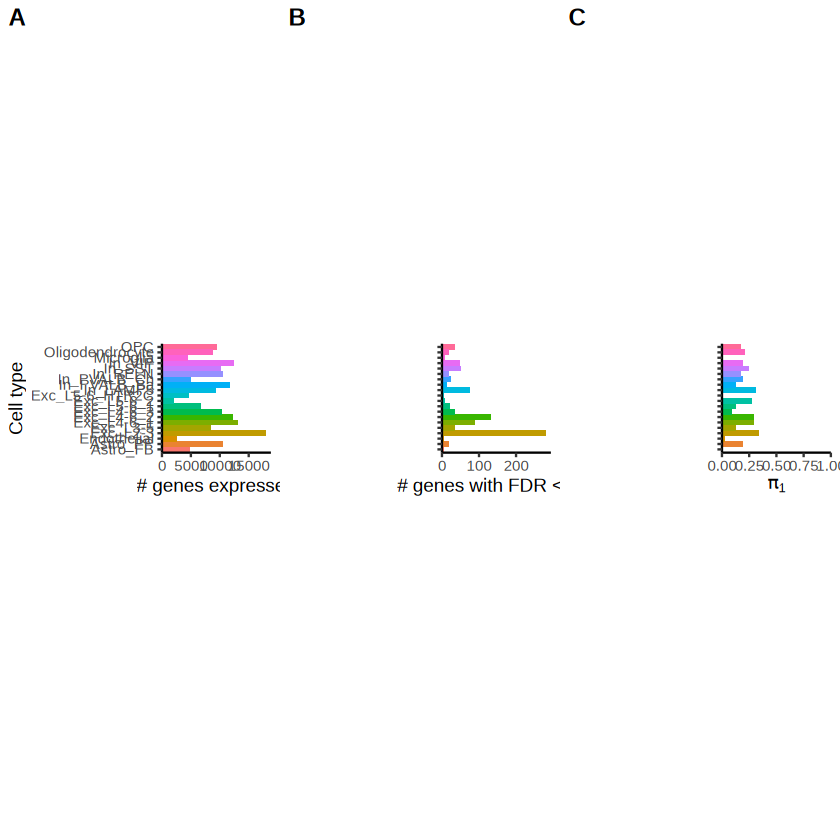

In [37]:
### Summarize differential expression 
### FDR <0.05
# Summarize differential expression for each coef and assay
df_de_cases = fit_cases %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes = length(adj.P.Val), 
      nDE = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
  mutate(assay = factor(assay))  

ymax = 1.05*max(df_de_cases$nGenes)
fig1 = ggplot(df_de_cases, aes(nGenes, assay, fill=assay)) + 
    geom_bar(stat="identity") + 
    theme_classic() +
    theme(aspect.ratio=1, legend.position="none") +
    scale_x_continuous(limits=c(0,ymax), expand=c(0,0)) +
    xlab("# genes expressed") +
    ylab("Cell type") 

ymax = max(1.05*max(df_de_cases$nDE), 100)
fig2 = ggplot(df_de_cases, aes(nDE, assay, fill=assay)) + 
    geom_bar(stat="identity") + 
    theme_classic() +
    theme(aspect.ratio=1, legend.position="none", axis.text.y=element_blank()) +
    scale_x_continuous(limits=c(0,ymax), expand=c(0,0)) +
    xlab("# genes with FDR < 5%") +
    ylab('')

fig3 = ggplot(df_de_cases, aes(pi1, assay, fill=assay)) + 
    geom_bar(stat="identity") + 
    theme_classic() +
    theme(aspect.ratio=1, legend.position="none", axis.text.y=element_blank()) +
    scale_x_continuous(limits=c(0,1), expand=c(0,0)) +
    xlab(bquote(pi[1]))+
    ylab('')

plot_grid(fig1, fig2, fig3, labels=LETTERS[1:3], nrow=1, axis="tblr", align="hv")   

In [38]:
df_de_controls

assay,nGenes,nDE,pi1
<fct>,<int>,<int>,<dbl>
Astro_FB,4572,25,0.2929661
Astro_PP,9643,32,0.2323164
Endothelial,3017,7,0.1662401
Exc_L2-3,17563,85,0.2735186
Exc_L3-5,8596,9,0.1752699
Exc_L4-6_1,12606,47,0.2082899
Exc_L4-6_2,11989,71,0.3015642
Exc_L4-6_3,8999,13,0.1596038
Exc_L5-6_1,6016,2,0.1219439


In [39]:
df_de_cases

assay,nGenes,nDE,pi1
<fct>,<int>,<int>,<dbl>
Astro_FB,4835,4,0.000000000
Astro_PP,10487,18,0.189352731
Endothelial,2449,3,0.019426012
Exc_L2-3,17937,280,0.333132728
Exc_L3-5,8413,34,0.124150669
Exc_L4-6_1,12986,89,0.291336388
Exc_L4-6_2,12277,131,0.285414762
Exc_L4-6_3,10230,35,0.084830087
Exc_L5-6_1,6750,20,0.121008678


# perform RRHO

In [2]:
suppressPackageStartupMessages({
library(RRHO2)})
#The input gene list should have 2 columns, 1st column is the gene symbol, 2nd column is the input score.
#The score should be calculated as -log10(pvalue) * sign(effectSize)

In [3]:
celltypes <- c('Exc_L2-3','Exc_L3-5','Exc_L4-6_1','Exc_L4-6_2','Exc_L4-6_3','Exc_L5-6_1','Exc_L5-6_2','Exc_L5-6_HTR2C',
               'In_LAMP5_1','In_LAMP5_2','In_PVALB_Ba','In_PVALB_Ch','In_RELN','In_SST','In_VIP','Astro_FB','Astro_PP',
               'Endothelial','Microglia','Oligodendrocyte','OPC')

DE_res_Age_list_controls <- list()
for (celltype in celltypes){
  DE_res_Age_list_controls[[celltype]] <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Ctrls_20231124.xlsx', sheet = celltype))
}

DE_res_Age_list_cases <- list()
for (celltype in celltypes){
  DE_res_Age_list_cases[[celltype]] <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Cases_20231124.xlsx', sheet = celltype))
}

In [4]:
DE_controls_combined <- dplyr::bind_rows(DE_res_Age_list_controls)
DE_cases_combined <- dplyr::bind_rows(DE_res_Age_list_cases)

df_de_ctrls = DE_controls_combined %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
        nGenes = length(adj.P.Val), 
        nDE_FDR0.1 = sum(adj.P.Val < 0.1),
        nDE_FDR0.05 = sum(adj.P.Val < 0.05))

df_de_ctrls

df_de_cases = DE_cases_combined %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
        nGenes = length(adj.P.Val), 
        nDE_FDR0.1 = sum(adj.P.Val < 0.1),
        nDE_FDR0.05 = sum(adj.P.Val < 0.05))

df_de_cases

assay,nGenes,nDE_FDR0.1,nDE_FDR0.05
<chr>,<int>,<int>,<int>
Astro_FB,4572,63,23
Astro_PP,9644,77,31
Endothelial,3017,15,7
Exc_L2-3,17565,214,80
Exc_L3-5,8599,24,8
Exc_L4-6_1,12611,136,44
Exc_L4-6_2,11987,192,69
Exc_L4-6_3,9002,53,13
Exc_L5-6_1,6020,22,2


assay,nGenes,nDE_FDR0.1,nDE_FDR0.05
<chr>,<int>,<int>,<int>
Astro_FB,4833,13,4
Astro_PP,10484,62,18
Endothelial,2451,5,3
Exc_L2-3,17934,575,280
Exc_L3-5,8411,67,34
Exc_L4-6_1,12982,222,89
Exc_L4-6_2,12276,265,131
Exc_L4-6_3,10230,91,35
Exc_L5-6_1,6752,49,20


In [4]:
# calculate score with UNadjusted p-value
Ctrls <- list()
Cases <- list()
input_Ctrls <- list()
input_Cases <- list()
for (celltype in names(DE_res_Age_list_controls)){
    #subset for all genes that were tested in both controls and cases
    Ctrls[[celltype]] <- DE_res_Age_list_controls[[celltype]][DE_res_Age_list_controls[[celltype]]$ID %in% DE_res_Age_list_cases[[celltype]]$ID, ]
    Cases[[celltype]] <- DE_res_Age_list_cases[[celltype]][DE_res_Age_list_cases[[celltype]]$ID %in% DE_res_Age_list_controls[[celltype]]$ID, ]
    #calculated score needed for RRHO2 input
    Ctrls[[celltype]]$score <- -log10(Ctrls[[celltype]]$`P.Value`) * Ctrls[[celltype]]$logFC
    Cases[[celltype]]$score <- -log10(Cases[[celltype]]$`P.Value`) * Cases[[celltype]]$logFC
    #format input for RRHO2; a simple dataframe with gene and score
    input_Ctrls[[celltype]] <- Ctrls[[celltype]][,c("ID","score")]
    input_Cases[[celltype]] <- Cases[[celltype]][,c("ID","score")]
}

In [5]:
n_genes_tested <- as.data.frame(matrix(ncol=4, nrow=length(names(input_Ctrls))))
colnames(n_genes_tested) <- c('celltype', 'n_genes', '%_genes_Ctrls', '%_genes_Cases')
idx <- 0
for (celltype in names(input_Ctrls)){
  idx <- idx +1
  n_genes_tested$celltype[idx] <- celltype
  n_genes_tested$n_genes[idx] <- length(input_Ctrls[[celltype]]$ID)
  n_genes_tested$`%_genes_Ctrls`[idx] <- length(DE_res_Age_list_controls[[celltype]]$ID)/n_genes_tested$n_genes[idx]*100
  n_genes_tested$`%_genes_Cases`[idx] <- length(DE_res_Age_list_cases[[celltype]]$ID)/n_genes_tested$n_genes[idx]*100
}
n_genes_tested

celltype,n_genes,%_genes_Ctrls,%_genes_Cases
<chr>,<int>,<dbl>,<dbl>
Exc_L2-3,17447,100.6763,102.7913
Exc_L3-5,8257,104.1419,101.8651
Exc_L4-6_1,12537,100.5903,103.5495
Exc_L4-6_2,11908,100.6634,103.0904
Exc_L4-6_3,8982,100.2227,113.8945
Exc_L5-6_1,5981,100.6521,112.8908
Exc_L5-6_2,1643,101.2781,119.4157
Exc_L5-6_HTR2C,3839,100.3647,120.3959
In_LAMP5_1,6943,100.5617,109.2611


## Extended Data Fig. 5

In [ ]:
RRHO2_list <- list()
for (celltype in names(input_Ctrls)){
  RRHO2_list[[celltype]] <- RRHO2_initialize(input_Ctrls[[celltype]], 
                                             input_Cases[[celltype]], labels = c("Controls", "Cases"), 
                                             log10.ind=TRUE)
}

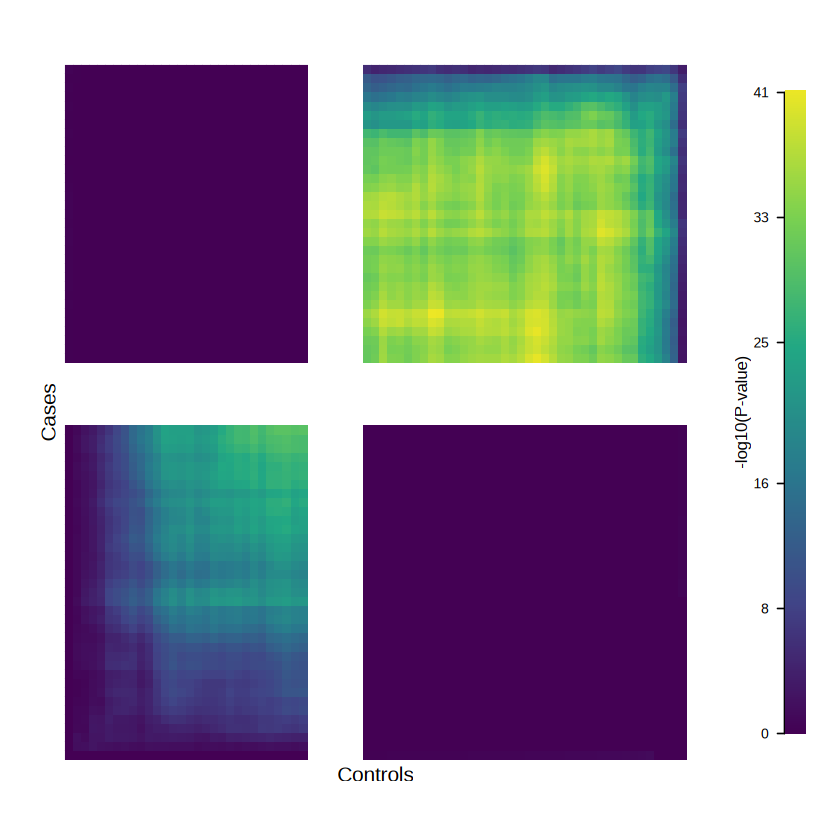

In [8]:
my_palette2 <- colorRampPalette(c("#440154FF", "#414487FF", "#2A788EFF", "#22A884FF", "#7AD151FF", '#EDE725FF'))(299)

RRHO2_heatmap(RRHO2_list[['In_LAMP5_2']], colorGradient = my_palette2)

In [9]:
for (celltype in names(RRHO2_list)){
  pdf(file = paste0('../figures/RRHO/', celltype, "_heatmap_Age_Case_Ctrl_unadj_pval.pdf"))
  RRHO2_heatmap(RRHO2_list[[celltype]], colorGradient = my_palette2)
  dev.off() 
}

# correlate logFC of signficant genes between cases and controls

In [6]:
# read in Age DE genes from full cohort
DE_res_Age <- list()
for (celltype in celltypes){
  DE_res_Age[[celltype]] <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_20231121.xlsx', sheet = celltype))
}

# select signficant genes 
DE_Age_sig <- list()
for (celltype in celltypes){
  DE_Age_sig[[celltype]] <- DE_res_Age[[celltype]][DE_res_Age[[celltype]]$adj.P.Val < 0.05,]
}

In [7]:
# select genes of Controls and of Cases that were significant genes in DE analysis in full cohort

Ctrls_Cases_combined <- list()
for (celltype in celltypes){
    tmp <- Ctrls[[celltype]][Ctrls[[celltype]]$ID %in% DE_Age_sig[[celltype]]$ID,]
    names(tmp)[names(tmp) == "logFC"] <- "logFC_Controls"
    tmp2 <- Cases[[celltype]][Cases[[celltype]]$ID %in% DE_Age_sig[[celltype]]$ID,]
    names(tmp2)[names(tmp2) == "logFC"] <- "logFC_Cases"
    Ctrls_Cases_combined[[celltype]] <- merge(tmp, tmp2, by='ID')
    Ctrls_Cases_combined[[celltype]] <-  Ctrls_Cases_combined[[celltype]] %>% mutate(Directionality = case_when(
    logFC_Controls >0 & logFC_Cases <0 ~ 'divergent',
    logFC_Controls <0 & logFC_Cases >0 ~ 'divergent',
    logFC_Controls <0 & logFC_Cases <0 ~ 'down',
    logFC_Controls >0 & logFC_Cases >0 ~ 'up'))
    Ctrls_Cases_combined[[celltype]]$Directionality <- factor( Ctrls_Cases_combined[[celltype]]$Directionality, levels=c('up', 'down', 'divergent'))   
}

### heatmap

In [16]:
# correlate logFC between Cases and Controls of DE genes significant in the full cohort
effect_size_corr <- as.data.frame(matrix(ncol=3,nrow=length(celltypes)))
colnames(effect_size_corr) <- c('celltype', 'Rho', 'p-val')
effect_size_corr$celltype <- celltypes
rownames(effect_size_corr) <- celltypes
for (celltype in celltypes){
    cor_test <- cor.test(Ctrls_Cases_combined[[celltype]]$logFC_Controls, Ctrls_Cases_combined[[celltype]]$logFC_Cases, 
                         method='spearman')
    effect_size_corr[celltype, 'Rho'] <- cor_test$estimate
     effect_size_corr[celltype, 'p-val'] <- cor_test$p.value
}
effect_size_corr$`adj.p-val` <- p.adjust(effect_size_corr$`p-val`, method='fdr', 
                                         n=length(effect_size_corr$`p-val`))
effect_size_corr

,celltype,Rho,p-val,adj.p-val
,<chr>,<dbl>,<dbl>,<dbl>
Exc_L2-3,Exc_L2-3,0.8206947,0.000000e+00,0.000000e+00
Exc_L3-5,Exc_L3-5,0.6299356,0.000000e+00,0.000000e+00
Exc_L4-6_1,Exc_L4-6_1,0.7790125,0.000000e+00,0.000000e+00
Exc_L4-6_2,Exc_L4-6_2,0.8223973,0.000000e+00,0.000000e+00
Exc_L4-6_3,Exc_L4-6_3,0.7846522,0.000000e+00,0.000000e+00
Exc_L5-6_1,Exc_L5-6_1,0.8403587,0.000000e+00,0.000000e+00
Exc_L5-6_2,Exc_L5-6_2,0.1188811,7.161843e-01,7.161843e-01
Exc_L5-6_HTR2C,Exc_L5-6_HTR2C,0.4982655,4.328819e-04,4.784485e-04
In_LAMP5_1,In_LAMP5_1,0.4350454,6.781756e-09,8.377463e-09


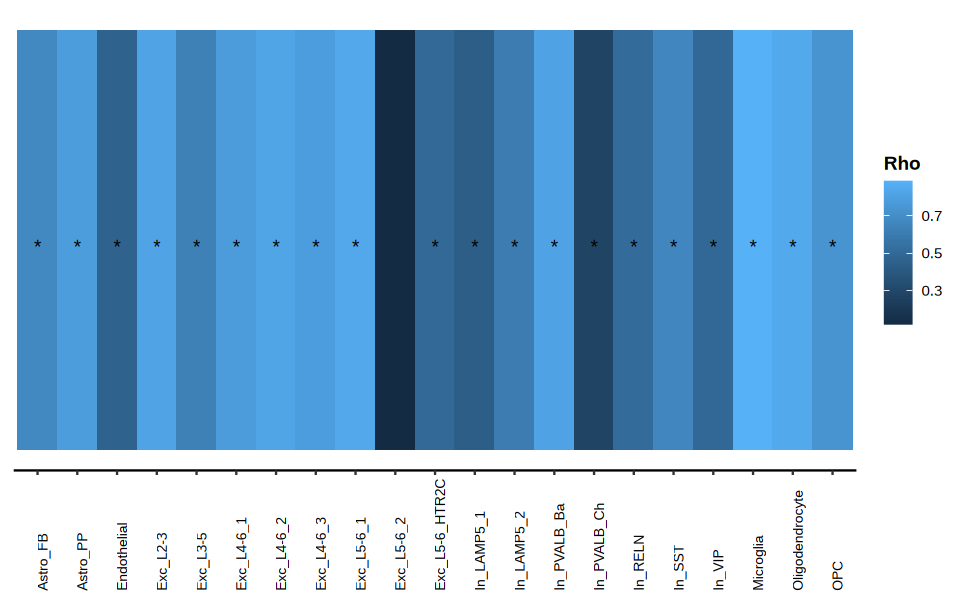

In [108]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(effect_size_corr, aes(x=celltype, y=1, fill= Rho, label = ifelse(`adj.p-val` < 0.05, "*", ""))) + 
  geom_tile() + theme_classic() + geom_text(vjust = 1, hjust = 0.5) +
  #scale_fill_viridis() +
  #scale_fill_gradient(low = "#D3D3D3", high = "#242424") +
  xlab("Cell Types") + theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=0, color="black", 
                                                                          size=8), axis.title.x=element_blank(),
                                               axis.text.y=element_blank(),axis.title.y=element_blank(), 
                                               axis.ticks.y=element_blank(), axis.line.y=element_blank(), 
                                               legend.title = element_text(face='bold'))

ggsave('../figures/correlation_heatmap_Age_DE_genes_Ctrls_vs_Cases.pdf', plot = last_plot(), height=3, width = 4)

# Session Info

In [111]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] data.table_1.14.8           ggpubr_0.6.0               
 [3] RRHO2_1.0                   VennDiagram_1.7.3          
 [5] futile.logger_1.4.3         writexl_1.4.2              
 [7]